In [ ]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

c:\users\tungd.laptop-8m0b2cr6\appdata\local\programs\python\python39\lib\site-packages\xgboost\compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [ ]:
train = pd.read_csv('device_2023_reducedCols.csv')

In [ ]:
train.isna().sum()

adverse_event_flag                             0
product_problems                               7
product_problem_flag                           0
date_of_event                              53533
device_date_of_manufacturer               298503
event_type                                    78
previous_use_code                          65450
device_age_text                           776298
manufacturer_d_name                         1159
date_received                                  0
patient_age                               660510
patient_sex                                    0
patient_weight                            664169
patient_ethnicity                        1053511
patient_race                             1141251
patient_problems                               3
sequence_number_outcome                        0
type_of_report                                 0
event_location                            998944
distributor_name                         1160541
distributor_state   

In [ ]:
DATE_COLUMNS =['date_of_event', 'device_date_of_manufacturer', 'date_received']
for i in DATE_COLUMNS:
    train[i] = pd.to_datetime(train[i], format="%Y%m%d")
    train[i + '_year'] = train[i].dt.year
    train[i + '_month'] = train[i].dt.month
    train[i + '_day'] = train[i].dt.day
    train.drop(columns=[i], inplace=True)

In [ ]:
train['patient_age'] = train['patient_age'].str.split(' ').apply(lambda x: 0 if isinstance(x, float) else 0 if len(x) == 1
                                                           else float(x[0])/12 if x[1] == 'MO'
                                                           else float(x[0])/365 if x[1] == 'DA'
                                                           else float(x[0])/52 if x[1] == 'WK'
                                                           else float(x[0]))
train['patient_weight'] = train['patient_weight'].str.split(' ').apply(lambda x: 0 if isinstance(x, float) else 0 if x[0] == 'KG' else float(x[0]))
train['device_age_text'] = train['device_age_text'].str.split(' ').apply(lambda x: x if isinstance(x, float) else 0 if len(x) == 1 else float(x[0])/12 if x[1] == 'MO' else float(x[0])/365 if x[1] == 'DA' else float(x[0]))

In [ ]:
train = train.dropna(axis=1, how='all')

In [ ]:
#train.drop(columns=['openfda.device_name', 'openfda.medical_specialty_description', ])

In [ ]:
train['adverse_event_flag'] = train['adverse_event_flag'].eq('Y').mul(1)
train['product_problem_flag'] = train['product_problem_flag'].eq('Y').mul(1)

In [ ]:
enc = OneHotEncoder()
enc_data = pd.DataFrame(enc.fit_transform(train[['event_type', 'previous_use_code', 'patient_sex', 'patient_ethnicity', 'event_location', 'openfda.medical_specialty_description']]).toarray())
enc_data.columns = enc.get_feature_names()
train.drop(columns=['event_type', 'previous_use_code', 'patient_sex', 'patient_ethnicity', 'event_location', 'openfda.medical_specialty_description'], inplace=True)

In [ ]:
train

,adverse_event_flag,product_problems,product_problem_flag,device_age_text,manufacturer_d_name,patient_age,patient_weight,patient_race,patient_problems,sequence_number_outcome,...,openfda.device_name,date_of_event_year,date_of_event_month,date_of_event_day,device_date_of_manufacturer_year,device_date_of_manufacturer_month,device_date_of_manufacturer_day,date_received_year,date_received_month,date_received_day
0,0,['Arcing'],1,NaN,"INTUITIVE SURGICAL, INC",0.0,121.0,NaN,"['No Clinical Signs, Symptoms or Conditions']",[''],...,"System, Surgical, Computer Controlled Instrument",2023.0,1.0,13.0,2022.0,7.0,15.0,2023,2,24
1,1,['Loss of Osseointegration'],0,NaN,INSTITUT STRAUMANN AG,57.0,0.0,NaN,['Fibrosis'],['Required Intervention'],...,"Implant, Endosseous, Root-Form",2022.0,11.0,21.0,2021.0,7.0,11.0,2023,1,5
2,0,['Appropriate Term/Code Not Available'],1,NaN,"DEXCOM, INC.",74.0,58.0,NaN,"['No Clinical Signs, Symptoms or Conditions']",[''],...,Integrated Continuous Glucose Monitoring Syste...,2023.0,1.0,23.0,NaN,NaN,NaN,2023,2,24
3,0,['Corroded'],1,NaN,CAREFUSION SD,0.0,0.0,NaN,"['No Clinical Signs, Symptoms or Conditions']",[''],...,"Pump, Infusion",2022.0,12.0,20.0,2005.0,10.0,18.0,2023,1,5
4,0,['Device Contamination with Chemical or Other ...,1,0.0,"AIZU OLYMPUS CO., LTD.",0.0,0.0,NaN,"['No Clinical Signs, Symptoms or Conditions']",[''],...,"Gastroscope And Accessories, Flexible/Rigid",2023.0,1.0,26.0,2020.0,8.0,19.0,2023,2,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1160536,0,['Leak/Splash'],1,0.0,BECTON DICKINSON MEDICAL (SINGAPORE),0.0,0.0,NaN,['Insufficient Information'],[''],...,"Catheter, Intravascular, Therapeutic, Short-Te...",2023.0,6.0,9.0,2022.0,12.0,29.0,2023,6,29
1160537,0,['Degraded'],1,NaN,"RESPIRONICS, INC.",0.0,0.0,NaN,"['No Clinical Signs, Symptoms or Conditions']",[''],...,"Ventilator, Non-Continuous (Respirator)",2023.0,6.0,10.0,2018.0,8.0,30.0,2023,6,30
1160538,0,"['Delivered as Unsterile Product', 'Contaminat...",1,0.0,CONVATEC LTD,0.0,0.0,NaN,"['No Clinical Signs, Symptoms or Conditions']",[''],...,"Dressing, Wound, Hydrophilic",NaN,NaN,NaN,2022.0,3.0,1.0,2023,6,30
1160539,1,"['Unable to Obtain Readings', 'Device Displays...",0,0.0,ABBOTT DIABETES CARE INC,0.0,0.0,NaN,"['Hypoglycemia', 'Loss of consciousness', 'Con...",['Required Intervention'],...,Integrated Continuous Glucose Monitoring Syste...,2023.0,6.0,22.0,2023.0,2.0,8.0,2023,6,30


In [ ]:
train = train.join(enc_data)

In [ ]:
#Cleaning
train_y = train['adverse_event_flag']
train_x = train.drop(columns=['adverse_event_flag'])

In [ ]:
train_x.drop(columns=['product_problems', 'manufacturer_d_name', 'patient_race', 'patient_problems', 'sequence_number_outcome', 'type_of_report', 'openfda.device_name'], inplace=True)
#train_x.drop(columns=['product_problem_flag'], inplace=True)

In [ ]:
#train_x['device_age_text'] = train_x['device_age_text'].fillna(0)

In [ ]:
train_x = train_x.dropna(axis=1, how='any')

#train_x['date_of_event_year'] = train_x['date_of_event_year'].fillna(2023)
#train_x['date_of_event_month'] = train_x['date_of_event_year'].fillna(1)
#train_x['date_of_event_day'] = train_x['date_of_event_year'].fillna(1)
#train_x['device_date_of_manufacturer_year'] = train_x['device_date_of_manufacturer_year'].fillna(2023)
#train_x['device_date_of_manufacturer_month'] = train_x['device_date_of_manufacturer_month'].fillna(1)
#train_x['device_date_of_manufacturer_day'] = train_x['device_date_of_manufacturer_day'].fillna(1)

In [ ]:
train_x.columns[train_x.isna().sum() > 0]

Index([], dtype='object')

In [ ]:
train_x.isna().sum()

product_problem_flag                 0
patient_age                          0
patient_weight                       0
date_received_year                   0
date_received_month                  0
date_received_day                    0
x0_Death                             0
x0_Injury                            0
x0_Malfunction                       0
x0_No answer provided                0
x0_Other                             0
x0_nan                               0
x1_*                                 0
x1_A                                 0
x1_I                                 0
x1_R                                 0
x1_U                                 0
x1_nan                               0
x2_Female                            0
x2_Intersex                          0
x2_Male                              0
x2_No Answer Provided                0
x2_Prefer Not To Disclose            0
x2_Transgender                       0
x3_Hispanic                          0
x3_Non Hispanic          

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(train_x, train_y, test_size=0.2, random_state=20230307)
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.25, random_state=20230307)

In [ ]:
clf = RandomForestClassifier(random_state=0, n_jobs=-1)
clf.fit(train_X, train_y)

RandomForestClassifier(n_jobs=-1, random_state=0)

In [ ]:
features = []
vals = []
total = []
i = 0
for feature in zip(train_X.columns, clf.feature_importances_):
    features.append(feature[0])
    vals.append(feature[1])
    total.append(feature)
    i += 1

In [ ]:
sorted_list = sorted(total, key=lambda x: x[1], reverse=True)

In [ ]:
features = []
vals = []
i = 0
for feature in sorted_list:
    if feature[0] == 'x0_Injury':
        continue

    features.append(feature[0])
    vals.append(feature[1])

    i += 1
    if i == 10:
        break

Text(0, 0.5, 'Feature')

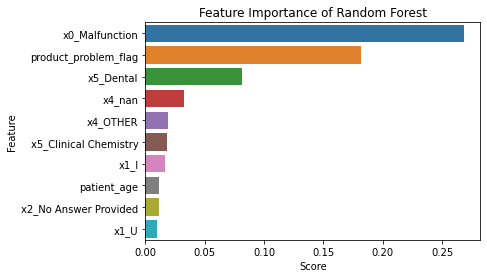

In [ ]:
import seaborn as sns
sns.barplot(y=features, x=vals).set_title("Feature Importance of Random Forest")
plt.xlabel('Score')
plt.ylabel('Feature')

In [ ]:
preds = clf.predict(val_X)

In [ ]:
bst = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic', eval_metric='auc')
model = bst.fit(train_X, train_y)
preds = model.predict(val_X)

c:\users\tungd.laptop-8m0b2cr6\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\tungd.laptop-8m0b2cr6\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py:208: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [ ]:
#preds = clf.predict(test_X)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

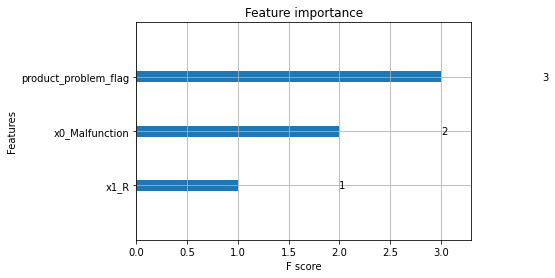

In [ ]:
from xgboost import plot_importance
plot_importance(model, max_num_features=10)

In [ ]:
print(roc_auc_score(preds,val_y))

0.9867890358834036


In [ ]:
sklearn.metrics.accuracy_score(roc_auc_score(preds))

In [ ]:
def confusio_matrix(y_test, y_predicted):
    cm = confusion_matrix(y_test, y_predicted)
    plt.figure(figsize=(15,10))
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    classNames = ['Negative','Positive']
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]

    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
    plt.show()

In [ ]:
def get_xgb_imp(xgb, feat_names):
    from numpy import array
    imp_vals = xgb.booster().get_fscore()
    imp_dict = {feat_names[i]:float(imp_vals.get('f'+str(i),0.)) for i in range(len(feat_names))}
    total = array(imp_dict.values()).sum()
    return {k:v/total for k,v in imp_dict.items()}
get_xgb_imp(bst,train_x.columns)

TypeError: 'NoneType' object is not callable

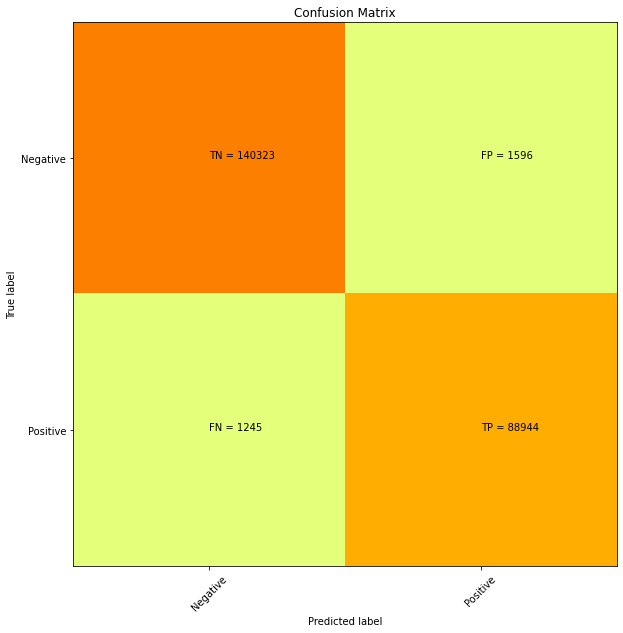

In [ ]:
confusio_matrix(val_y, preds)

In [ ]:
preds = bst.predict(test_X)

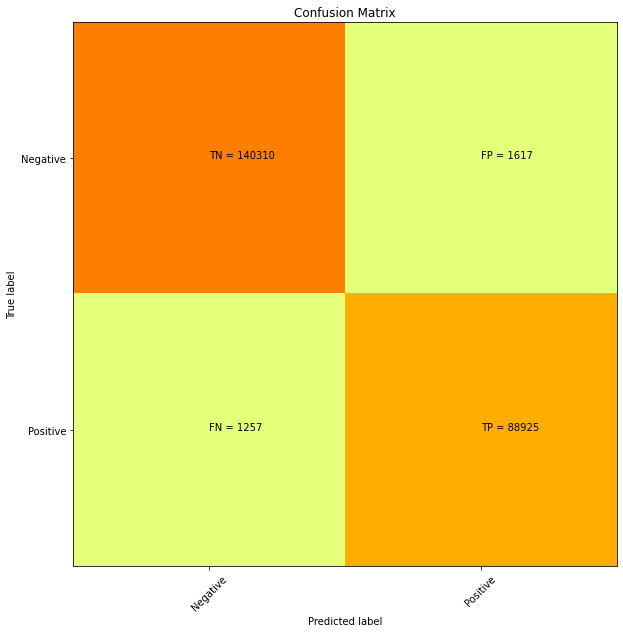

In [ ]:
confusio_matrix(test_y, preds)